In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
dbFile = 'baseline_v1.3_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
class WackySummaryMetric(metrics.BaseMetric):
    def __init__(self, nside, col=None, **kwargs):
        self.nside = nside
        super(WackySummaryMetric, self).__init__(metricName='wacky',col=col, **kwargs)
        if col is None:
            self.col = 'metricdata'
    def run(self, dataSlice, slicePoint=None):
        # let's assume we are running on a coadded depth
        
        # Chop off any outliers
        good_pix = np.where(dataSlice[self.col] > 0)[0]
        area = hp.nside2pixarea(self.nside, degrees=True) * np.size(good_pix)
        median_depth = np.median(dataSlice[self.col][good_pix])
        # Here's some value with strange units of mags*deg^2
        result = area*median_depth
        return result

In [4]:
nside = 64
bundleList = []
sql = 'filter="r"'
metric = metrics.ExgalM5()
slicer = slicers.HealpixSlicer(nside=nside)
plotDict = {'colorMax': 27.4, 'colorMin': 20}

summary = [WackySummaryMetric(nside)]
summary.append(metrics.MedianMetric())
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summary))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter="r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 481373 visits
Running:  ['opsim_ExgalM5_fiveSigmaDepth_r_HEAL']


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/slicers/baseSpatialSlicer.py:108: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside (64) different from map value (128), using slicer value
  % (slicePoints['nside'],self.nside ))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 4313 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 25.3698  dipole: lon: 78.2149, lat: -28.5362, amp: 1.3671
Plotting complete.


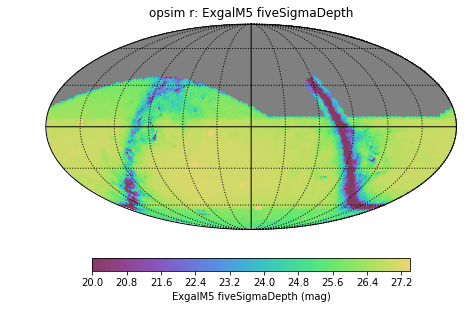

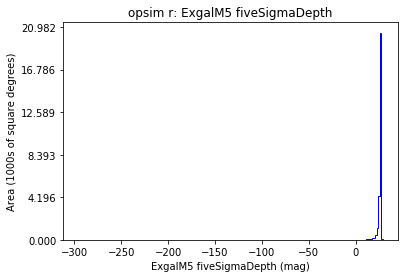

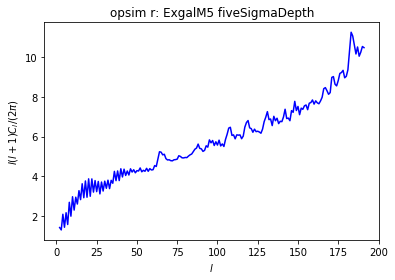

In [5]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

bg.plotAll(closefigs=False)


In [6]:
# And here are the results
bundleList[0].summaryValues

{'wacky': 725034.5006652712, 'Median': 26.669287531025063}